In [2]:
# add function folders
import sys
sys.path.append( '../thermalStressIndex2cor/' )

# Global input / packages
from packages import *
from parameters import *

# General functions
from gis_functions import *
from remote_sensing_functions import *
from meteo_functions import *
from aggregate_functions import *

# Specific functions for land surface temperature correction
from eb_tir_cor_functions import *

from initialization import *

In [3]:
# =============================================================================
# Set WD and create folder to save results
# =============================================================================

os.chdir(os.path.join(path2wd,name,"ffid"+str(idfeu)))

# create folder to save results
folder2save_tircor=os.path.join('ffid'+str(idfeu)+'_tir_topocor')

os.makedirs(folder2save_tircor,exist_ok=True)

In [10]:
# =============================================================================
# Selection of dates 
# =============================================================================
# Global remote sensing data 
datathermal=dd.read_csv(os.path.join("rs_data","ffid"+str(idfeu)+"*.csv"),
                       dtype={'tile':str})

# Time metadata
time_rsdata=pd.read_csv(os.path.join("rs_data",'rs_meta_time.csv'))

# Air temperature 
tair_disagg=dd.read_csv(os.path.join('ffid'+str(idfeu)+"_ta_disaggregated",'ffid'+str(idfeu)+"_ta_disag*.csv"))[['ind','date','hour','ta','ta_d']]

# selection of dates according to [Penot,2023]
print("# Selecting satellite time overpass and scenes ...")

dates_ok=dates_selection(datathermal,time_rsdata,tair_disagg,idfeu,
                         freq_min_pix=freq_min_pix,
                         dtemp_min=dtemp_min,
                         start_hour=start_hour, end_hour=end_hour,
                         min_month=min_month,max_month=max_month,
                         clear_soil_pixel=clear_soil_pixel,
                         clear_water_pixel=clear_water_pixel,
                         fill_no_data=fill_no_data)

dates_ok.sort_values(by=['date_datetime'],inplace=True)

print("---> Number of dates to correct (if not done) :", len(dates_ok))

# get already corrected dates and remove from dates to correct
if len(glob.glob(os.path.join(folder2save_tircor,'ffid*_tir_topocor*.csv')))>0:
    
    done_dates=dd.read_csv(os.path.join(folder2save_tircor,"ffid"+str(idfeu)+"_tir_topocor_*.csv"))['date'].unique().compute()
    dates_ok=dates_ok.loc[~dates_ok['date'].isin(done_dates)]

print("---> Number of dates to correct :", len(dates_ok))

# =============================================================================
# study area points / centroid of pixels 
# =============================================================================

# /!\ long et lat mais x,y, xf yf sont bien dans le crs safran 
points,xf,yf=get_points_location(path2points,
                                 point_file=point_file,path2dem=path2dem,safran_crs=safran_crs,
                                 x_safran=x_safran,y_safran=y_safran,
                                 parameters=['elevation','slope','aspect'],
                                 longlat=True,init_coord=True)



# Selecting satellite time overpass and scenes ...
---> Number of dates to correct (if not done) : 101
---> Number of dates to correct : 0


In [ ]:
# =============================================================================
# Wind and specific humidity data loading
# =============================================================================

print("# Loading wind speed and specific humidity data ... ")
# wind speed
safran_ws = xr.open_mfdataset(os.path.join(path2safran,prefix_product_ws+"*.nc"), 
                              combine='by_coords',parallel=True)

# specific humidity 
safran_q = xr.open_mfdataset(os.path.join(path2safran,prefix_product_q+"*.nc"), 
                             combine='by_coords',parallel=True)


print("---> Done")

In [5]:
# =============================================================================
# per date land surface temperature correction for topographic effects
# =============================================================================

print("# Start land surface temperature correction for topographic effects")
for i in range(len(dates_ok)) : 
        
    # date 
    date=dates_ok.iloc[i]['date']

    # hour
    hour=int(dates_ok.iloc[i]['hour'].mean())

    # minute
    minute=int(dates_ok.iloc[i]['minute'].mean())

    # satellite
    sat=dates_ok.iloc[i]['sat']

    if type(sat)!=str:
        sat='l'+str(int(sat))

    # tile
    tile=dates_ok.iloc[i]['tile']

    # tair mean [K]
    tair_mean=dates_ok.iloc[i]['ta_d'].mean()
    
    print("\n \n #", i+1, "out of", len(dates_ok), "/ Date ",date,hour,":",minute," / Sat : ",sat," / tile : ",str(tile))

    # get tair by ind
    # air temperature data of the day from previous step
    tair_disagg_ind=dd.read_csv(os.path.join('ffid'+str(idfeu)+"_ta_disaggregated",'ffid'+str(idfeu)+"_ta_disag_"+date+".csv"))[['ind','date','hour','ta','ta_d']]
    # air temperature data at satellite overpass time 
    tair_ind=get_tair(tair_disagg_ind.compute(),
                      time_rsdata=time_rsdata,col='ta_d',agg_col='date',start_hour=start_hour,end_hour=end_hour)
    
    print("---> Tair evaluated")
    
    # get rs data
    if read_from_dask :
        
        rs_data=datathermal.loc[(datathermal['date']==date) 
                                    & (datathermal['sat']==sat) 
                                    & (datathermal['tile']==tile)
                                    & (datathermal['qa_pixel'].isin([clear_soil_pixel[sat],clear_water_pixel[sat]]))].compute()

    else :
        
        rs_data=dd.read_csv(os.path.join("rs_data","ffid"+str(idfeu)+"*"+date+"*.csv"),dtype={'tile':str})

        rs_data=rs_data.loc[(rs_data['date']==date) 
                                    & (rs_data['sat']==sat) 
                                    & (rs_data['tile']==tile)
                                    & (rs_data['qa_pixel'].isin([clear_soil_pixel[sat],clear_water_pixel[sat]]))].compute()
    
    # start correction of lst 
    tir_sim_data=get_tir_correction(tair_ind,
                                    time_rsdata, 
                                    rs_data,
                                    points,xf,yf,
                                    safran_ws,safran_q,
                                    date,hour,minute,sat,tile,
                                    ncpu=ncpu,
                                    eb_params=eb_params,
                                    wet_edge_comp=False,
                                    col_ta='ta_d',
                                    x_safran=x_safran,y_safran=y_safran,time_safran=time_safran,
                                    name_product_q=name_product_q,name_product_ws=name_product_ws,
                                    window_size=window_size,window_size_tir=window_size_tir)
    
    path2savefile=os.path.join(folder2save_tircor,"ffid"+str(idfeu)+"_tir_topocor_"+str(date)+".csv")

    if os.path.exists(path2savefile):
        tir_sim_data.to_csv(path2savefile,mode="a",header=False,index=False)
    else :
        tir_sim_data.to_csv(path2savefile,mode="w",header=True,index=False)

# Start land surface temperature correction for topographic effects

 
 # 1 out of 101 / Date  2013-04-24 10 : 25  / Sat :  l7  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 20643
---> Selected number of pixels :19057

---> Per pixel tir simulation ... 
Lapse rate : -0.00158 [K.m^-1]
Tsd mean [K]:  305.47006591576485
Tsw mean [K] : 290.8229885450066
Tvd mean [K] : 298.81164514055666
Tvw mean [K] : 290.8229885450066
Number of values all data:  19057
Number of values all data without na :  19057
Global fss_opt=0.9 / fsv_opt=0.4
Local fss_opt=0.9 / fsv_opt=0.38

---> Mean tir simulation ... 
Tsd mean [K]:  305.4940798840611
Tsw mean [K] : 290.8229885450066
Tvd mean [K] : 298.84406453459104
Tvw mean [K] : 290.8229885450066

 
 # 2 out of 101 / Date  2013-05-10 10 : 25  / Sat :  l7  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial 

Tvd mean [K] : 301.15502170666235
Tvw mean [K] : 292.64815358005865
Number of values all data:  22522
Number of values all data without na :  22522
Global fss_opt=0.9 / fsv_opt=0.30000000000000004
Local fss_opt=0.92 / fsv_opt=0.38

---> Mean tir simulation ... 
Tsd mean [K]:  308.1713002638125
Tsw mean [K] : 292.64815358005865
Tvd mean [K] : 301.1760019350355
Tvw mean [K] : 292.64815358005865

 
 # 12 out of 101 / Date  2014-05-13 10 : 27  / Sat :  l7  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 20728
---> Selected number of pixels :19578

---> Per pixel tir simulation ... 
Lapse rate : -0.00536 [K.m^-1]
Tsd mean [K]:  301.7069140652292
Tsw mean [K] : 289.47371143968104
Tvd mean [K] : 295.7486979211411
Tvw mean [K] : 289.47371143968104
Number of values all data:  19578
Number of values all data without na :  19578
Global fss_opt=1.0 / fsv_opt=0.4
Local fss_opt=1.0 / fsv_opt=0.4

---> Mean tir 


 
 # 22 out of 101 / Date  2015-06-25 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23608
---> Selected number of pixels :22535

---> Per pixel tir simulation ... 
Lapse rate : -0.00416 [K.m^-1]
Tsd mean [K]:  317.8133578483332
Tsw mean [K] : 300.1950925472132
Tvd mean [K] : 309.8635438856422
Tvw mean [K] : 300.1950925472132
Number of values all data:  22535
Number of values all data without na :  22535
Global fss_opt=1.0 / fsv_opt=0.9
Local fss_opt=1.0 / fsv_opt=0.86

---> Mean tir simulation ... 
Tsd mean [K]:  317.835858904116
Tsw mean [K] : 300.1950925472132
Tvd mean [K] : 309.8767742540511
Tvw mean [K] : 300.1950925472132

 
 # 23 out of 101 / Date  2015-07-11 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23621
---> Selected number of pixels :22582

---> P

Global fss_opt=0.8 / fsv_opt=0.2
Local fss_opt=0.78 / fsv_opt=0.18000000000000002

---> Mean tir simulation ... 
Tsd mean [K]:  295.8910596531028
Tsw mean [K] : 286.84959393477436
Tvd mean [K] : 291.36361984345575
Tvw mean [K] : 286.84959393477436

 
 # 33 out of 101 / Date  2016-04-08 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23582
---> Selected number of pixels :22450

---> Per pixel tir simulation ... 
Lapse rate : -0.00346 [K.m^-1]
Tsd mean [K]:  294.795037068998
Tsw mean [K] : 284.2812374463996
Tvd mean [K] : 289.5958282277222
Tvw mean [K] : 284.2812374463996
Number of values all data:  22450
Number of values all data without na :  22450
Global fss_opt=0.9 / fsv_opt=0.5
Local fss_opt=0.88 / fsv_opt=0.44

---> Mean tir simulation ... 
Tsd mean [K]:  294.7710543765674
Tsw mean [K] : 284.2812374463996
Tvd mean [K] : 289.58327868097473
Tvw mean [K] : 284.2812374463996


Tsd mean [K]:  302.89812275397475
Tsw mean [K] : 290.56467129181647
Tvd mean [K] : 297.04247240188323
Tvw mean [K] : 290.56467129181647
Number of values all data:  19229
Number of values all data without na :  19229
Global fss_opt=0.6000000000000001 / fsv_opt=0.5
Local fss_opt=0.56 / fsv_opt=0.4

---> Mean tir simulation ... 
Tsd mean [K]:  302.912645955087
Tsw mean [K] : 290.56467129181647
Tvd mean [K] : 297.04515314189837
Tvw mean [K] : 290.56467129181647

 
 # 44 out of 101 / Date  2017-04-19 10 : 32  / Sat :  l7  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23570
---> Selected number of pixels :22558

---> Per pixel tir simulation ... 
Lapse rate : -0.00133 [K.m^-1]
Tsd mean [K]:  301.2476447337693
Tsw mean [K] : 287.90537043892675
Tvd mean [K] : 295.07581840451456
Tvw mean [K] : 287.90537043892675
Number of values all data:  22558
Number of values all data without na :  22558
Global fss_op


 
 # 54 out of 101 / Date  2018-07-03 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 20148
---> Selected number of pixels :18633

---> Per pixel tir simulation ... 
Lapse rate : -0.00672 [K.m^-1]
Tsd mean [K]:  319.7639554388653
Tsw mean [K] : 301.98136937532956
Tvd mean [K] : 311.7987386563468
Tvw mean [K] : 301.98136937532956
Number of values all data:  18633
Number of values all data without na :  18633
Global fss_opt=0.8 / fsv_opt=0.5
Local fss_opt=0.78 / fsv_opt=0.5

---> Mean tir simulation ... 
Tsd mean [K]:  319.78627085328236
Tsw mean [K] : 301.98136937532956
Tvd mean [K] : 311.811496867158
Tvw mean [K] : 301.98136937532956

 
 # 55 out of 101 / Date  2018-07-11 10 : 29  / Sat :  l7  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23115
---> Selected number of pixels :21635

-

Global fss_opt=1.0 / fsv_opt=0.2
Local fss_opt=1.0 / fsv_opt=0.2

---> Mean tir simulation ... 
Tsd mean [K]:  308.5987691673005
Tsw mean [K] : 296.2158812106087
Tvd mean [K] : 302.56412165454753
Tvw mean [K] : 296.2158812106087

 
 # 65 out of 101 / Date  2019-06-04 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23638
---> Selected number of pixels :22660

---> Per pixel tir simulation ... 
Lapse rate : -0.00656 [K.m^-1]
Tsd mean [K]:  310.93573657265136
Tsw mean [K] : 295.8255054555927
Tvd mean [K] : 303.9910167375354
Tvw mean [K] : 295.8255054555927
Number of values all data:  22660
Number of values all data without na :  22660
Global fss_opt=0.8 / fsv_opt=0.4
Local fss_opt=0.8 / fsv_opt=0.44000000000000006

---> Mean tir simulation ... 
Tsd mean [K]:  310.96292415384306
Tsw mean [K] : 295.8255054555927
Tvd mean [K] : 304.0027381425302
Tvw mean [K] : 295.8255054555927

 


Tsd mean [K]:  305.6202167004575
Tsw mean [K] : 290.569937781016
Tvd mean [K] : 298.50597887578164
Tvw mean [K] : 290.569937781016
Number of values all data:  22569
Number of values all data without na :  22569
Global fss_opt=0.8 / fsv_opt=0.6000000000000001
Local fss_opt=0.76 / fsv_opt=0.56

---> Mean tir simulation ... 
Tsd mean [K]:  305.72057716826714
Tsw mean [K] : 290.569937781016
Tvd mean [K] : 298.5630046000955
Tvw mean [K] : 290.569937781016

 
 # 76 out of 101 / Date  2020-04-03 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23591
---> Selected number of pixels :22477

---> Per pixel tir simulation ... 
Lapse rate : 0 [K.m^-1]
Tsd mean [K]:  299.9889549460115
Tsw mean [K] : 286.93736451527013
Tvd mean [K] : 293.9775614939984
Tvw mean [K] : 286.93736451527013
Number of values all data:  22477
Number of values all data without na :  22477
Global fss_opt=0.70000000000


 
 # 86 out of 101 / Date  2021-05-08 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23606
---> Selected number of pixels :22495

---> Per pixel tir simulation ... 
Lapse rate : -0.00183 [K.m^-1]
Tsd mean [K]:  310.2806551584821
Tsw mean [K] : 293.8967130051182
Tvd mean [K] : 302.9600151202656
Tvw mean [K] : 293.8967130051182
Number of values all data:  22495
Number of values all data without na :  22495
Global fss_opt=1.0 / fsv_opt=0.30000000000000004
Local fss_opt=1.0 / fsv_opt=0.30000000000000004

---> Mean tir simulation ... 
Tsd mean [K]:  310.3137832000021
Tsw mean [K] : 293.8967130051182
Tvd mean [K] : 302.98019085409356
Tvw mean [K] : 293.8967130051182

 
 # 87 out of 101 / Date  2021-06-09 10 : 29  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23589
---> Selecte

Global fss_opt=0.9 / fsv_opt=0.7000000000000001
Local fss_opt=0.9400000000000001 / fsv_opt=0.8

---> Mean tir simulation ... 
Tsd mean [K]:  313.595530048095
Tsw mean [K] : 297.44264917925074
Tvd mean [K] : 306.34585723367513
Tvw mean [K] : 297.44264917925074

 
 # 97 out of 101 / Date  2022-06-12 10 : 30  / Sat :  l8  / tile :  197030
---> Tair evaluated
---> Wind speed interpollated 
---> Specific humidity interpollated 
---> Initial number of pixels : 23613
---> Selected number of pixels :22554

---> Per pixel tir simulation ... 
Lapse rate : -0.00397 [K.m^-1]
Tsd mean [K]:  322.4874948546579
Tsw mean [K] : 305.4090947823696
Tvd mean [K] : 314.8883326315367
Tvw mean [K] : 305.4090947823696
Number of values all data:  22554
Number of values all data without na :  22554
Global fss_opt=1.0 / fsv_opt=0.7000000000000001
Local fss_opt=1.0 / fsv_opt=0.7000000000000001

---> Mean tir simulation ... 
Tsd mean [K]:  322.5101552929974
Tsw mean [K] : 305.4090947823696
Tvd mean [K] : 314.9040618

In [6]:
# =============================================================================
# Illustrations of the process 
# =============================================================================

In [11]:
# ===
# study area points / centroid of pixels 
# ===
points,_,_=get_points_location(path2points,
                                 point_file=point_file,path2dem=path2dem,safran_crs=safran_crs,
                                 x_safran=x_safran,y_safran=y_safran,
                                 longlat=False,init_coord=True)
# ===
# load a given lst corrected date 
# ===

date="2015-06-25"

df=dd.read_csv(os.path.join(folder2save_tircor,"ffid"+str(idfeu)+"_tir_topocor_"+date+".csv"))

rs_data=dd.read_csv(os.path.join("rs_data","ffid"+str(idfeu)+"*"+date+"*.csv"),dtype={'tile':str})
rs_data=rs_data.loc[(rs_data['date']==date)]

df=df.merge(rs_data[['ind','tir']],on='ind')
df=df.merge(points,on='ind').compute()

No handles with labels found to put in legend.


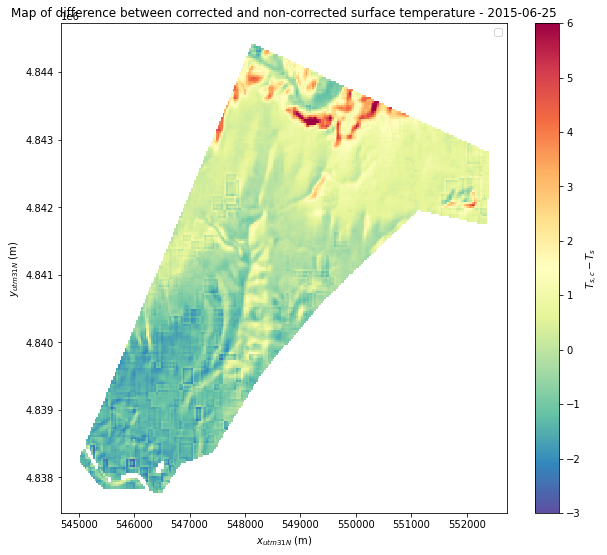

In [12]:
# ===
# gifference LST corrected minus LST measured
# ===

aspect_plot=(df.y_i.max()-df.y_i.min())/(df.x_i.max()-df.x_i.min())
width_plot=10
figure,axis = plt.subplots(figsize = (width_plot,width_plot*aspect_plot)) 
orig_map=plt.cm.get_cmap('Spectral')
reversed_map = orig_map.reversed()
density=axis.scatter(df.x_i,df.y_i,s=6,c=(df.tir_c-df.tir),
                    cmap=reversed_map, marker="s",vmin=6, vmax=-3)
figure.colorbar(density, label='$T_{s,c}-T_s$')
plt.xlabel('$x_{utm31N}$ (m)')
plt.ylabel('$y_{utm31N}$ (m)')
plt.title("Map of difference between corrected and non-corrected surface temperature - "+date)
plt.legend()
plt.show()

No handles with labels found to put in legend.


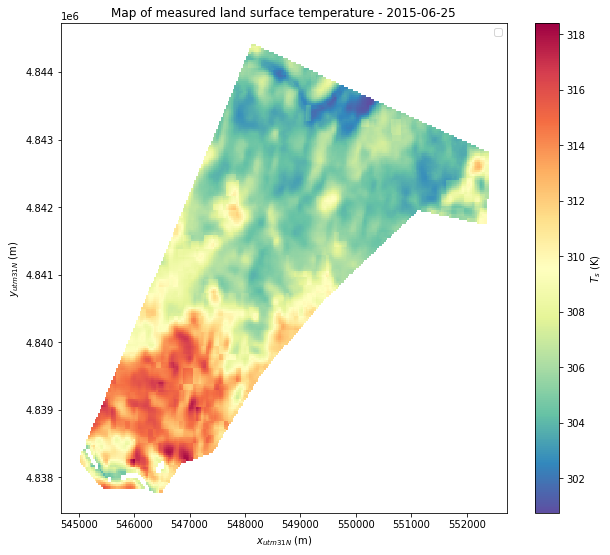

In [13]:
# ===
# LST corrected 
# ===
aspect_plot=(df.y_i.max()-df.y_i.min())/(df.x_i.max()-df.x_i.min())
width_plot=10
figure,axis = plt.subplots(figsize = (width_plot,width_plot*aspect_plot)) 
# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('Spectral')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
density=axis.scatter(df.x_i,df.y_i,s=6,c=(df.tir),
                    cmap=reversed_map, marker="s",vmin=df.tir.min(), vmax=df.tir.max())
figure.colorbar(density, label='$T_{s}$ (K)')
plt.xlabel('$x_{utm31N}$ (m)')
plt.ylabel('$y_{utm31N}$ (m)')
plt.title("Map of measured land surface temperature - "+date)
plt.legend()
plt.show()

No handles with labels found to put in legend.


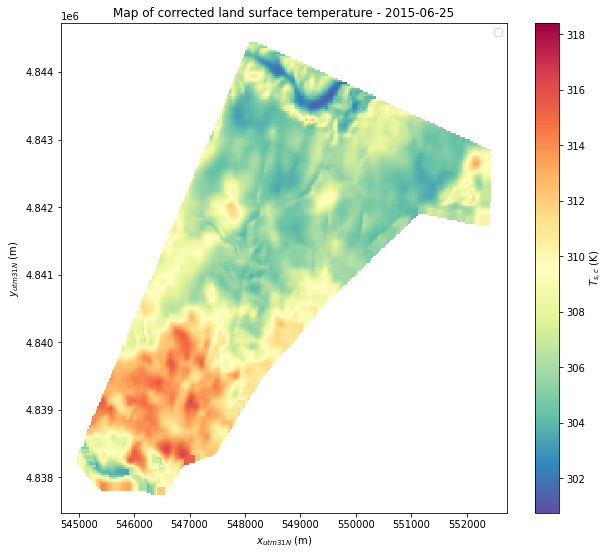

In [14]:
# ===
# LST measured
# ===
aspect_plot=(df.y_i.max()-df.y_i.min())/(df.x_i.max()-df.x_i.min())
width_plot=10
figure,axis = plt.subplots(figsize = (width_plot,width_plot*aspect_plot)) 
# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('Spectral')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
density=axis.scatter(df.x_i,df.y_i,s=50,c=(df.tir_c),
                    cmap=reversed_map, marker="s",vmin=df.tir.min(), vmax=df.tir.max())
figure.colorbar(density, label='$T_{s,c}$ (K)')
plt.xlabel('$x_{utm31N}$ (m)')
plt.ylabel('$y_{utm31N}$ (m)')
plt.title("Map of corrected land surface temperature - "+date)
plt.legend()
plt.show()

No handles with labels found to put in legend.


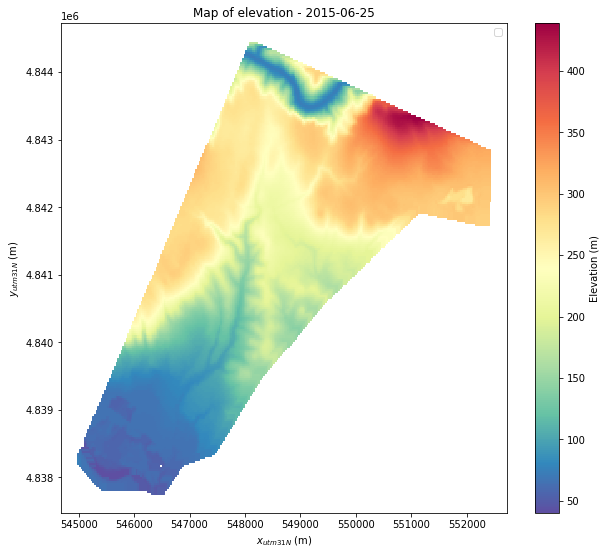

In [15]:
# ===
# Elevation
# ===
aspect_plot=(df.y_i.max()-df.y_i.min())/(df.x_i.max()-df.x_i.min())
width_plot=10
figure,axis = plt.subplots(figsize = (width_plot,width_plot*aspect_plot)) 
# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('Spectral')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
density=axis.scatter(df.x_i,df.y_i,s=50,c=(df.elevation),
                    cmap=reversed_map, marker="s",vmin=df.elevation.min(), vmax=df.elevation.max())
figure.colorbar(density, label='Elevation (m)')
plt.xlabel('$x_{utm31N}$ (m)')
plt.ylabel('$y_{utm31N}$ (m)')
plt.title("Map of elevation - "+date)
plt.legend()
plt.show()